task1

In [3]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [4]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import numpy as np
import json
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm

In [12]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()
device = torch.device("cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [7]:
dataset_path = "./TestDataSet"  # Your extracted image dataset path
dataset = ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [23]:
# Load label mapping (a flat list of class IDs)
with open('./TestDataSet/labels_list.json', 'r') as f:
    class_list = json.load(f)  # Example: ["n02971356", "n02974003", ...]

# Create mapping from index to class ID
# Extract just the label name after the colon
idx_to_class = {idx: class_id.split(": ")[1] for idx, class_id in enumerate(class_list)}

In [24]:
from torchvision.models import ResNet34_Weights

# Get list of 1000 class IDs (e.g., ["n01440764", "n01443537", ...])
imagenet_class_ids = ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

# Create mapping: class ID (e.g., "n01440764") → index (0 to 999)
classid_to_idx = {cls_id: idx for idx, cls_id in enumerate(imagenet_class_ids)}

In [25]:
top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)
        top1_preds = top5_preds[:, 0]

        # Map dataset labels (0–99) → ImageNet indices (0–999)
        correct_labels = torch.tensor([
            classid_to_idx[idx_to_class[labels[i].item()]]
            for i in range(len(labels))
        ], device=labels.device)

        top1_batch = (top1_preds == correct_labels)
        top5_batch = torch.tensor([
            correct_labels[i].item() in top5_preds[i]
            for i in range(len(labels))
        ], dtype=torch.bool, device=labels.device)

        top1_correct += top1_batch.sum().item()
        top5_correct += top5_batch.sum().item()
        total += labels.size(0)

top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Top-5 Accuracy: {top5_acc:.4f}")

100%|██████████| 16/16 [00:18<00:00,  1.14s/it]

✅ Top-1 Accuracy: 0.7600
✅ Top-5 Accuracy: 0.9400


TASK 2

In [26]:
import torch
import torch.nn.functional as F

def fgsm_attack(model, image, label, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    
    model.zero_grad()
    loss.backward()
    
    # Compute sign of gradient
    grad_sign = image.grad.data.sign()
    
    # Apply perturbation
    perturbed_image = image + epsilon * grad_sign
    
    # Clamp to [0, 1] range (after reversing normalization)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image.detach()

In [27]:
epsilon = 0.02
adv_images = []
adv_labels = []

model.eval()
for img, label in tqdm(dataloader):
    img = img.to(device)
    label = label.to(device)
    adv_img = fgsm_attack(model, img, label, epsilon)
    adv_images.append(adv_img.cpu())
    adv_labels.append(label.cpu())

# Stack into tensors
adv_images = torch.cat(adv_images)
adv_labels = torch.cat(adv_labels)

100%|██████████| 16/16 [00:53<00:00,  3.32s/it]


In [28]:
torch.save((adv_images, adv_labels), "adversarial_testset_1.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6400001..2.117904].


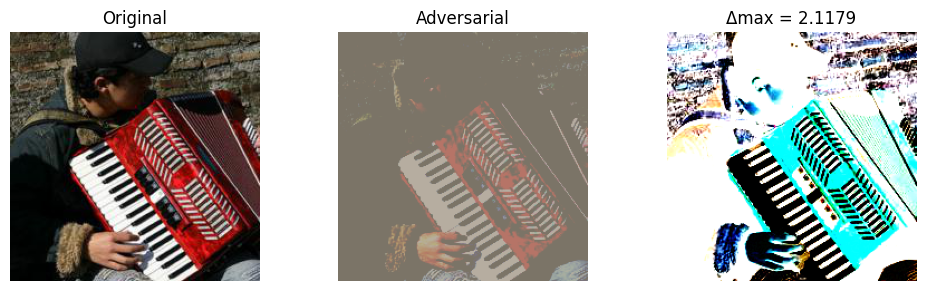

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4308496..2.117904].


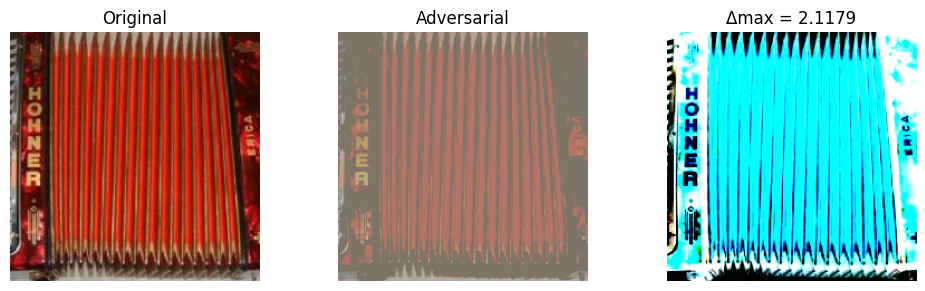

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6400001..2.117904].


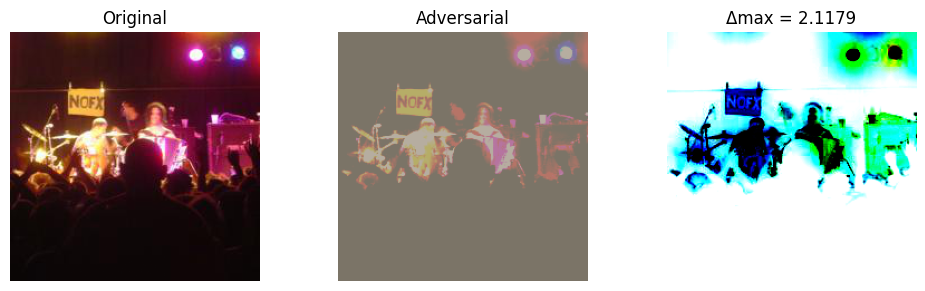

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6400001..2.117904].


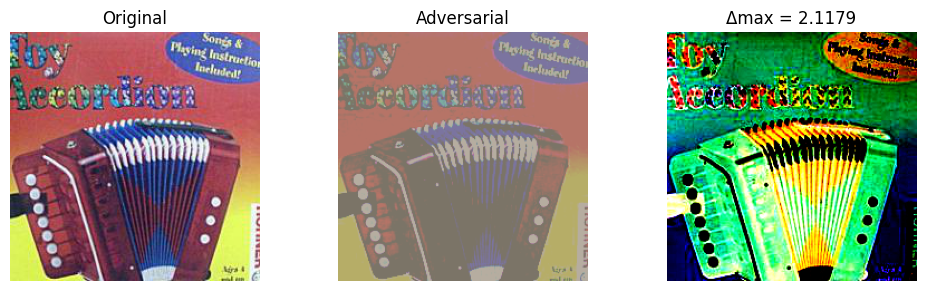

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6400001..2.117904].


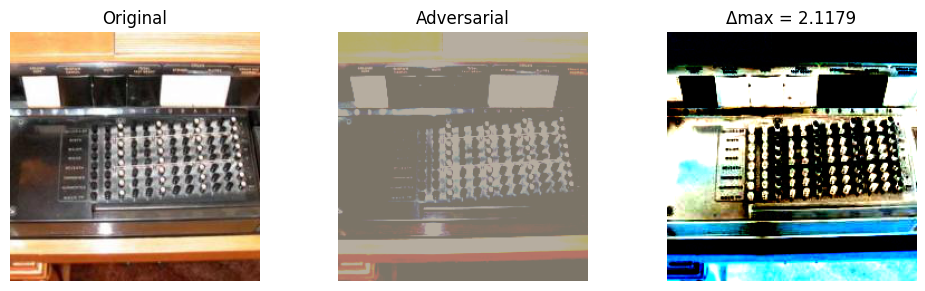

In [29]:
import matplotlib.pyplot as plt

# De-normalize function
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_tensor * std + mean

for i in range(5):
    orig_img, label = dataset[i]
    adv_img = adv_images[i]
    
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(denormalize(orig_img).permute(1,2,0).numpy())
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Adversarial")
    plt.imshow(denormalize(adv_img).permute(1,2,0).numpy())
    plt.axis("off")

    plt.subplot(1,3,3)
    diff = (adv_img - orig_img).abs().max().item()
    plt.title(f"Δmax = {diff:.4f}")
    plt.imshow((adv_img - orig_img).squeeze().permute(1,2,0).numpy())
    plt.axis("off")

    plt.tight_layout()
    plt.show()

TASK 3

In [41]:
def pgd_attack(model, image, label, epsilon=0.02, alpha=0.004, num_iter=10):
    original_image = image.clone().detach()
    perturbed = image.clone().detach().requires_grad_(True)

    for _ in range(num_iter):
        output = model(perturbed)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()
        grad_sign = perturbed.grad.data.sign()

        perturbed = perturbed + alpha * grad_sign

        # Project back to the ε-L∞ ball relative to the original (normalized) image
        perturbed = torch.max(torch.min(perturbed, original_image + epsilon), original_image - epsilon)

        # Clamp to valid range after denormalizing if you're visualizing
        perturbed = torch.clamp(perturbed, 0, 1).detach().requires_grad_()

    return perturbed.detach()

In [42]:
adv2_images = []
adv2_labels = []

model.eval()
for img, label in tqdm(dataloader):
    img = img.to(device)
    label = label.to(device)
    adv_img = pgd_attack(model, img, label, epsilon=0.02, alpha=0.004, num_iter=10)
    adv2_images.append(adv_img.cpu())
    adv2_labels.append(label.cpu())

adv2_images = torch.cat(adv2_images)
adv2_labels = torch.cat(adv2_labels)
torch.save((adv2_images, adv2_labels), "adversarial_testset_2.pt")

100%|██████████| 16/16 [13:42<00:00, 51.41s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.117904].


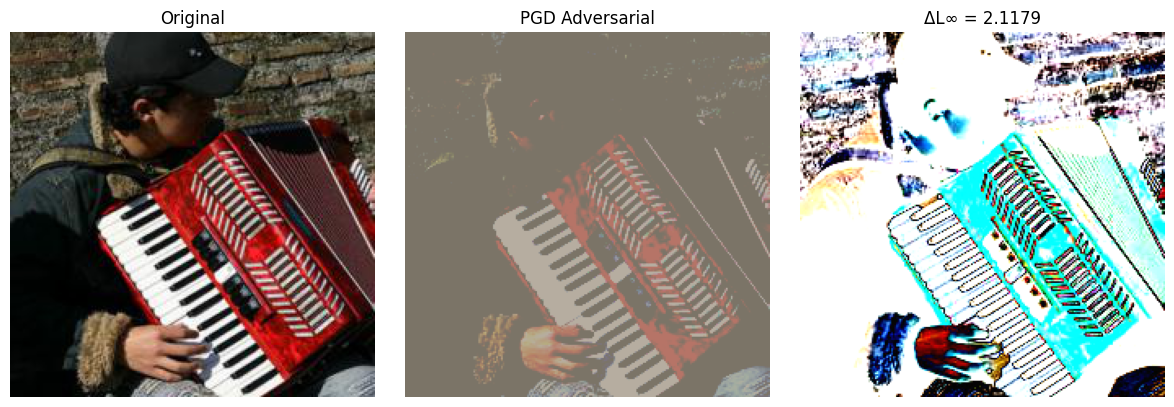

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.117904].


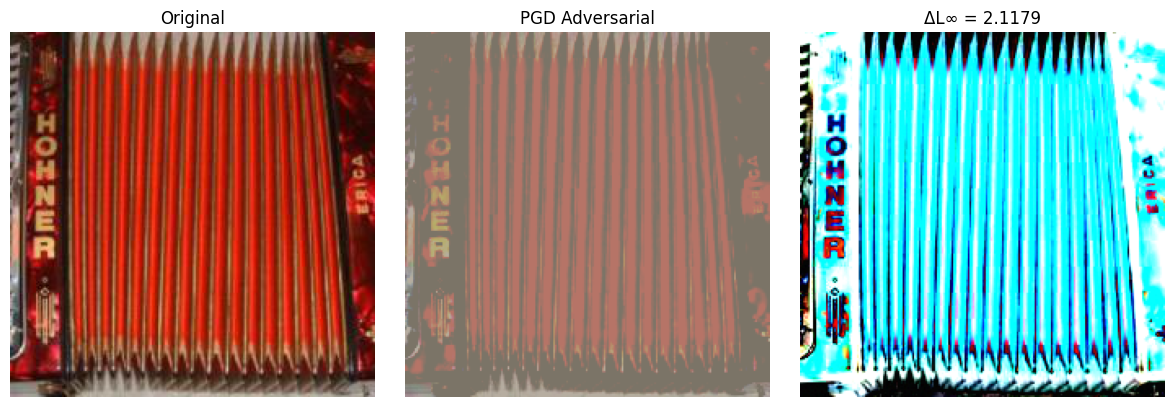

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.117904].


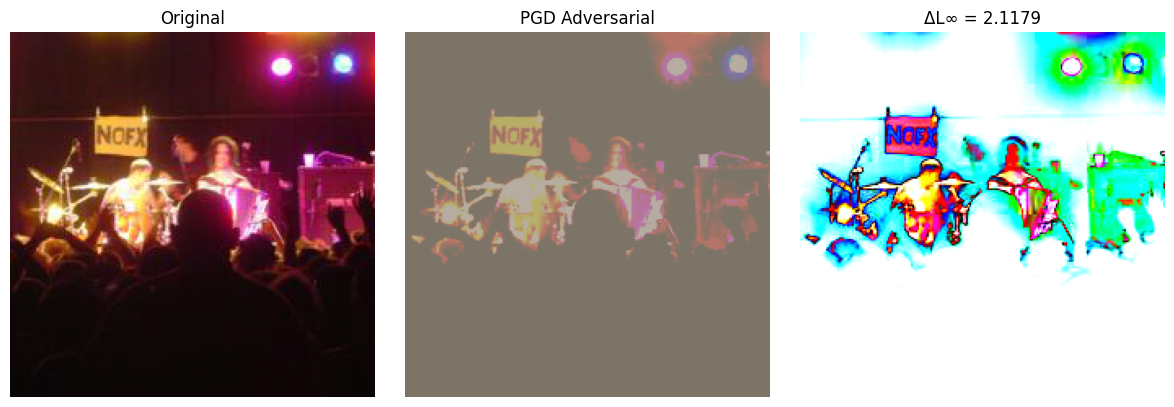

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.117904].


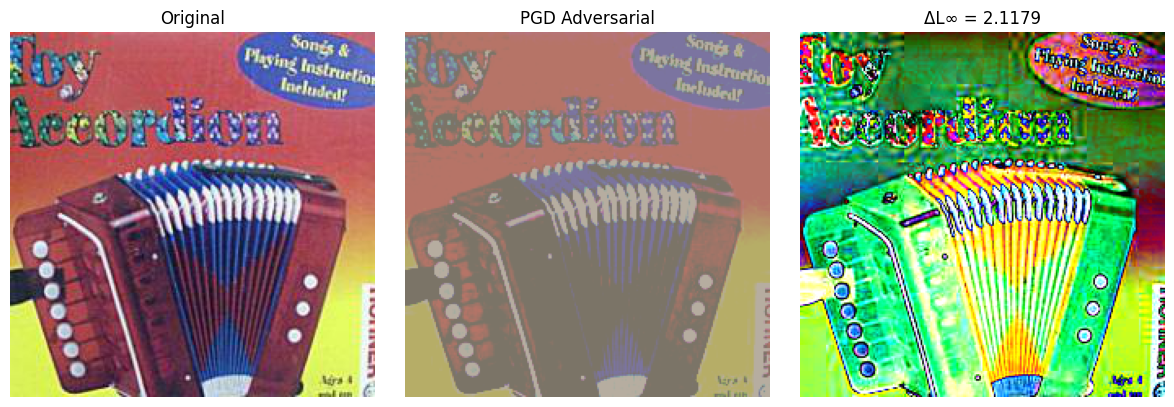

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.117904].


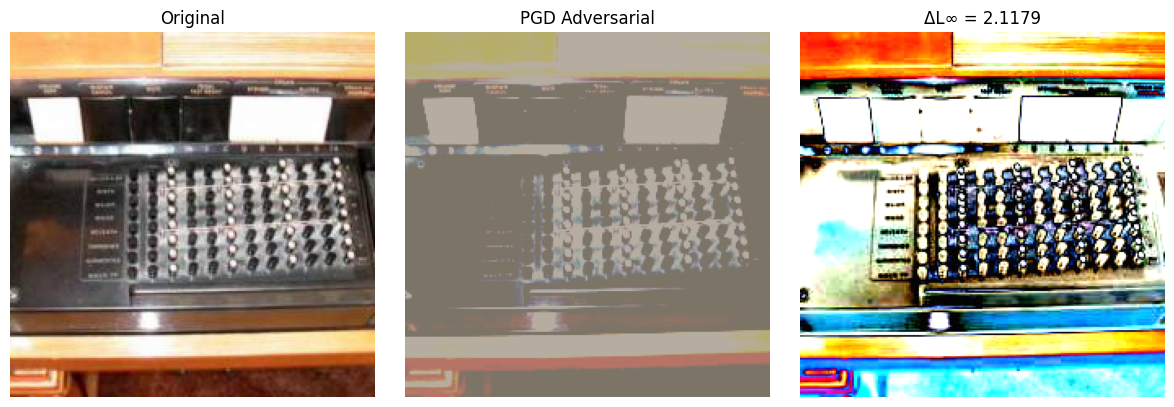

In [46]:
# PGD visuals
for i in range(5):
    orig_img, label = dataset[i]       # From original (clean) dataset
    adv_img = adv2_images[i]           # From PGD adversarial set

    orig_img = orig_img.to(adv_img.device)

    # De-normalize for display
    orig_vis = denormalize(orig_img).permute(1, 2, 0).cpu().numpy()
    adv_vis = denormalize(adv_img).permute(1, 2, 0).cpu().numpy()
    diff_vis = (adv_img - orig_img).permute(1, 2, 0).abs().cpu().numpy()

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(orig_vis)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("PGD Adversarial")
    plt.imshow(adv_vis)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    delta = diff_vis.max()
    plt.title(f"ΔL∞ = {delta:.4f}")
    plt.imshow(diff_vis, cmap='inferno')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [45]:
adv2_dataset = torch.utils.data.TensorDataset(adv2_images, adv2_labels)
adv2_loader = torch.utils.data.DataLoader(adv2_dataset, batch_size=32, shuffle=False)

In [ ]:
top1_correct = 0
top5_correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, top5_preds = outputs.topk(5, dim=1)
        top1_preds = top5_preds[:, 0]

        # Map dataset labels (0–99) → ImageNet indices (0–999)
        correct_labels = torch.tensor([
            classid_to_idx[idx_to_class[labels[i].item()]]
            for i in range(len(labels))
        ], device=labels.device)

        top1_batch = (top1_preds == correct_labels)
        top5_batch = torch.tensor([
            correct_labels[i].item() in top5_preds[i]
            for i in range(len(labels))
        ], dtype=torch.bool, device=labels.device)

        top1_correct += top1_batch.sum().item()
        top5_correct += top5_batch.sum().item()
        total += labels.size(0)

top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"✅ Top-1 Accuracy: {top1_acc:.4f}")
print(f"✅ Top-5 Accuracy: {top5_acc:.4f}")

TASK4

In [ ]:
def patch_pgd_attack(model, image, label, epsilon=0.3, alpha=0.05, num_iter=20, patch_size=32):
    original = image.clone().detach()
    perturbed = image.clone().detach().requires_grad_(True)

    C, H, W = image.shape

    # Random top-left corner of the patch
    x = (W - patch_size) // 2
    y = (H - patch_size) // 2

    for _ in range(num_iter):
        output = model(perturbed.unsqueeze(0))  # Add batch dim
        loss = F.cross_entropy(output, label.unsqueeze(0))

        model.zero_grad()
        loss.backward()

        grad_sign = perturbed.grad.data.sign()

        # Extract and update patch only
        patch_grad = grad_sign[:, y:y+patch_size, x:x+patch_size]
        orig_patch = original[:, y:y+patch_size, x:x+patch_size]
        pert_patch = perturbed[:, y:y+patch_size, x:x+patch_size]

        pert_patch = pert_patch + alpha * patch_grad
        pert_patch = torch.clamp(pert_patch, orig_patch - epsilon, orig_patch + epsilon)

        # SAFE update — no in-place op on leaf var
        new_perturbed = perturbed.clone().detach()
        new_perturbed[:, y:y+patch_size, x:x+patch_size] = pert_patch.detach()
        perturbed = new_perturbed.requires_grad_()

    return perturbed.detach()

In [58]:
adv3_images = []
adv3_labels = []

model.eval()

for batch_imgs, batch_labels in tqdm(dataloader):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    for i in range(batch_imgs.size(0)):
        img = batch_imgs[i]
        label = batch_labels[i]

        adv_img = patch_pgd_attack(model, img, label, epsilon=0.3, alpha=0.05, num_iter=20)
        adv3_images.append(adv_img.cpu())
        adv3_labels.append(label.cpu())

adv3_images = torch.stack(adv3_images)
adv3_labels = torch.stack(adv3_labels)

torch.save((adv3_images, adv3_labels), "adversarial_testset_3.pt")

100%|██████████| 16/16 [16:06<00:00, 60.43s/it]


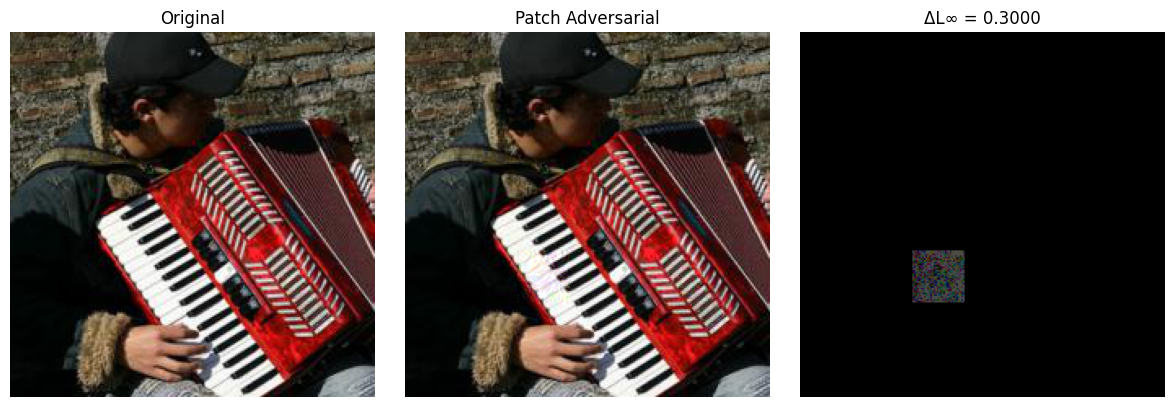

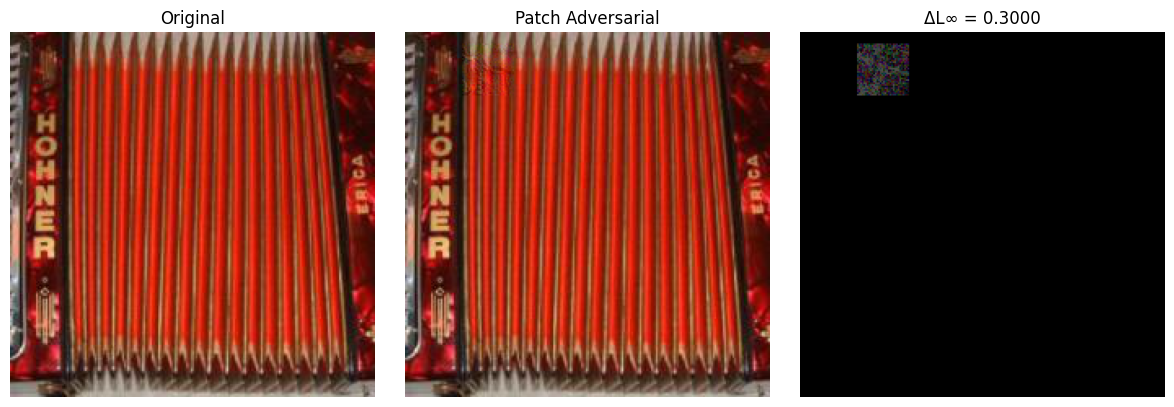

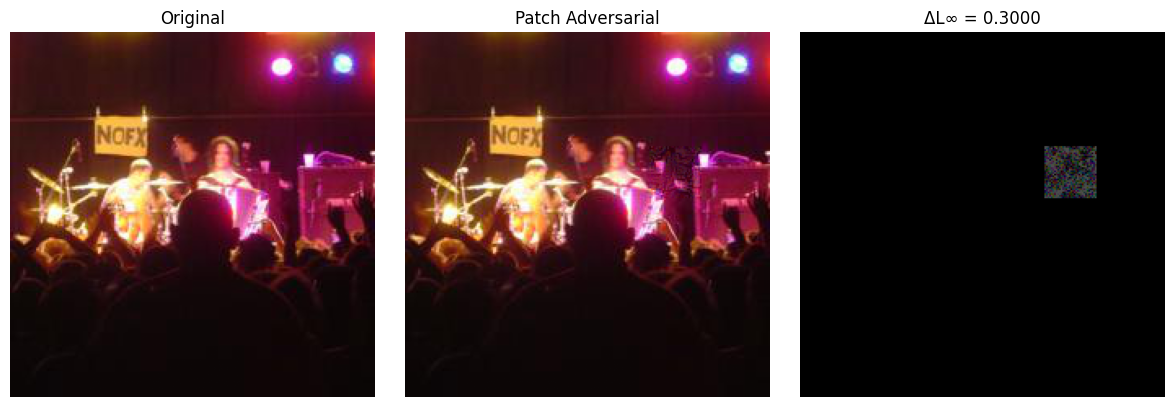

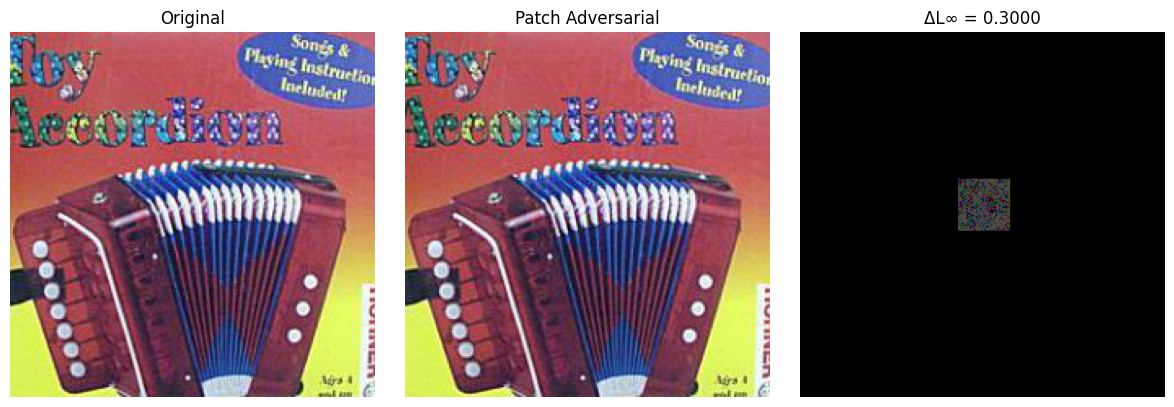

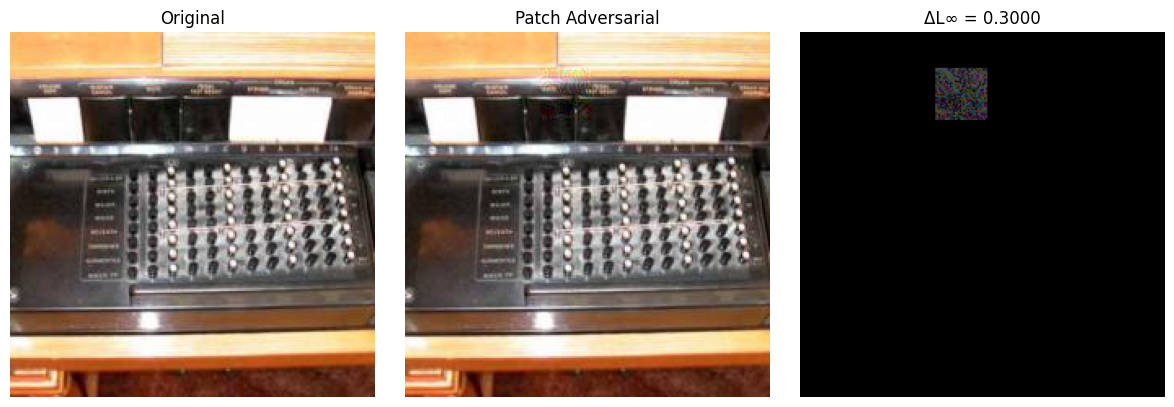

In [59]:
import matplotlib.pyplot as plt
import torch

# De-normalize function
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
    return torch.clamp(img_tensor * std + mean, 0, 1)

# Visualize 5 examples from Adversarial Test Set 3
for i in range(5):
    orig_img, label = dataset[i]           # Original image
    adv_img = adv3_images[i]               # Patch adversarial image

    orig_img = orig_img.to(adv_img.device)

    # De-normalize
    orig_vis = denormalize(orig_img).permute(1, 2, 0).cpu().numpy()
    adv_vis = denormalize(adv_img).permute(1, 2, 0).cpu().numpy()
    diff_vis = (adv_img - orig_img).permute(1, 2, 0).abs().cpu().numpy()

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(orig_vis)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Patch Adversarial")
    plt.imshow(adv_vis)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    delta = diff_vis.max()
    plt.title(f"ΔL∞ = {delta:.4f}")
    plt.imshow(diff_vis, cmap='inferno')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [60]:
adv3_dataset = torch.utils.data.TensorDataset(adv3_images, adv3_labels)
adv3_loader = torch.utils.data.DataLoader(adv3_dataset, batch_size=32, shuffle=False)

In [70]:
import json

# Step 1: Load and parse your label list
with open('./TestDataSet/labels_list.json') as f:
    label_strings = json.load(f)

# Step 2: Build mapping: folder_idx (0-99) → ImageNet label (int)
folder_to_imagenet = {
    folder_idx: int(label_str.split(":")[0])
    for folder_idx, label_str in enumerate(label_strings)
}

# Step 3: Convert all adv3_labels to ImageNet labels
label_tensor3 = torch.tensor([folder_to_imagenet[int(lbl)] for lbl in adv3_labels])

In [71]:
from torch.utils.data import DataLoader, TensorDataset
# Prepare dataset and evaluate
adv_dataset3 = TensorDataset(adv3_images, label_tensor3)
adv_loader3 = DataLoader(adv_dataset3, batch_size=32, shuffle=False)

top1_correct, top5_correct, total = 0, 0, 0
model.eval()

with torch.no_grad():
    for inputs, targets in adv_loader3:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, top5_preds = outputs.topk(5, dim=1)

        top1_correct += (top5_preds[:, 0] == targets).sum().item()
        for i in range(targets.size(0)):
            if targets[i].item() in top5_preds[i]:
                top5_correct += 1
        total += targets.size(0)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"🧨 Patch Attack Top-1 Accuracy: {top1_acc:.2f}%")
print(f"🧨 Patch Attack Top-5 Accuracy: {top5_acc:.2f}%")

🧨 Patch Attack Top-1 Accuracy: 75.40%
🧨 Patch Attack Top-5 Accuracy: 94.00%


In [72]:
print("Original adv3_labels:", adv3_labels[:5])
print("Mapped ImageNet labels:", label_tensor3[:5])

Original adv3_labels: tensor([0, 0, 0, 0, 0])
Mapped ImageNet labels: tensor([401, 401, 401, 401, 401])


TASK 5

In [74]:
import torchvision.models as models

# Load DenseNet-121 pretrained on ImageNet
new_model = models.densenet121(weights='IMAGENET1K_V1')
new_model = new_model.to(device).eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/eshikajanbandhu/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100.0%


In [75]:
def evaluate_model(model, dataloader):
    top1_correct = 0
    top5_correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, top5 = outputs.topk(5, dim=1)

            top1_correct += (top5[:, 0] == targets).sum().item()
            for i in range(targets.size(0)):
                if targets[i].item() in top5[i]:
                    top5_correct += 1
            total += targets.size(0)

    top1 = top1_correct / total * 100
    top5 = top5_correct / total * 100
    return top1, top5

In [ ]:
# Reuse your DataLoaders from previous tasks
datasets = {
    "Original": original_loader,
    "FGSM": adv_loader,   # Adversarial Test Set 1
    "PGD": adv2_loader,    # Adversarial Test Set 2
    "Patch PGD": adv3_loader  # Adversarial Test Set 3
}

results = {}

for name, loader in datasets.items():
    t1, t5 = evaluate_model(new_model, loader)
    results[name] = (t1, t5)
    print(f"📊 {name} → Top-1: {t1:.2f}% | Top-5: {t5:.2f}%")

NameError: name 'original_loader' is not defined